In [90]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

In [91]:
df = pd.read_csv('GRAB.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-01,13.595,13.63,11.01,11.01,11.01,8964400
1,2021-12-02,13.055,13.29,8.13,8.75,8.75,35751200
2,2021-12-03,9.160,9.52,8.45,8.99,8.99,29667200
3,2021-12-06,8.950,9.10,8.23,9.00,9.00,25416000
4,2021-12-07,9.055,9.06,8.32,8.85,8.85,25775900


In [92]:
df = df[['Date', 'Close']]
df

,Date,Close
0,2021-12-01,11.01
1,2021-12-02,8.75
2,2021-12-03,8.99
3,2021-12-06,9.00
4,2021-12-07,8.85
...,...,...
502,2023-11-30,3.04
503,2023-12-01,3.07
504,2023-12-04,3.15
505,2023-12-05,3.14


In [93]:
import datetime 

def str_to_datetime(s): 
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


In [94]:


df['Date'] = df['Date'].apply(lambda x: str_to_datetime(x))
df

,Date,Close
0,2021-12-01,11.01
1,2021-12-02,8.75
2,2021-12-03,8.99
3,2021-12-06,9.00
4,2021-12-07,8.85
...,...,...
502,2023-11-30,3.04
503,2023-12-01,3.07
504,2023-12-04,3.15
505,2023-12-05,3.14


In [95]:
df.index = df.pop('Date') # pops are set Date as index column
#df.index = df.set_index('Date') # pops are set Date as index column

### Plot data

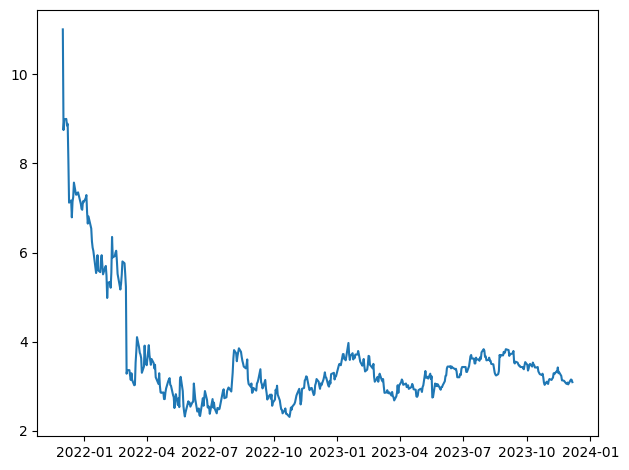

In [96]:
plt.plot(df.index, df['Close'])
plt.tight_layout()

Because using LSTM we will turn it into a supervised problem

In [98]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps, first_date_str='2022-01-01', last_date_str='2023-11-29'): 
    """ Shift Close price(t-n), then remove all rows whit nan values """
    
    df =dc(df)

    if first_date_str and last_date_str: 
        first_date = str_to_datetime(first_date_str)
        first_date = first_date - datetime.timedelta(days= n_steps)
        last_date = str_to_datetime(last_date_str)

        df = df.loc[first_date:last_date]

    for i in range(1, n_steps+1): 
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df



,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2022-01-05,6.90,7.29,7.22,7.13,7.15,6.96,6.98,7.09
2022-01-06,6.65,6.90,7.29,7.22,7.13,7.15,6.96,6.98
2022-01-07,6.81,6.65,6.90,7.29,7.22,7.13,7.15,6.96
2022-01-10,6.60,6.81,6.65,6.90,7.29,7.22,7.13,7.15
2022-01-11,6.54,6.60,6.81,6.65,6.90,7.29,7.22,7.13
...,...,...,...,...,...,...,...,...
2023-11-22,3.13,3.13,3.23,3.31,3.29,3.42,3.32,3.33
2023-11-24,3.12,3.13,3.13,3.23,3.31,3.29,3.42,3.32
2023-11-27,3.06,3.12,3.13,3.13,3.23,3.31,3.29,3.42


In [1]:
shifted_df = shifted_df.to_numpy() 
type(shifted_df)


NameError: name 'shifted_df' is not defined

Run Scaler 

In [100]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Scale features between -1 and 1
shifted_df = scaler.fit_transform(shifted_df)
shifted_df

array([[ 1.        ,  1.        ,  0.97188748, ...,  0.86746991,
         0.87550203,  0.91967879],
       [ 0.89106754,  0.84337355,  1.        , ...,  0.94377515,
         0.86746991,  0.87550203],
       [ 0.96078425,  0.74297194,  0.84337355, ...,  0.93574303,
         0.94377515,  0.86746991],
       ...,
       [-0.67320263, -0.67469882, -0.67068266, ..., -0.59839358,
        -0.6064257 , -0.55421682],
       [-0.67755992, -0.69879518, -0.67469882, ..., -0.63052206,
        -0.59839358, -0.6064257 ],
       [-0.66448804, -0.70281124, -0.69879518, ..., -0.67068266,
        -0.63052206, -0.59839358]])

In [101]:
X = shifted_df[:, 1:]
y = shifted_df[:, 0]

X.shape, y.shape, type(X)

((478, 7), (478,), numpy.ndarray)

In [102]:
X = dc(np.flip(X, axis=1)) # flip because need sequence from "old" to "new"


In [103]:
split_index = int(len(X) * .9)
split_index

430

In [104]:
X_train = X[:split_index].reshape(-1, lookback, 1)
X_test = X[split_index:].reshape(-1, lookback, 1)

y_train = y[:split_index].reshape(-1, 1)
y_test = y[split_index:].reshape(-1, 1)


X_train.shape, X_test.shape, y_train.shape, y_test.shape


((430, 7, 1), (48, 7, 1), (430, 1), (48, 1))

In [105]:
import torch 

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()


In [106]:
from torch.utils.data import Dataset 



class TimeSeriesDataset(Dataset): 

    def __init__(self, data, label):
        self.data = data
        self.label = label 
        
    def __len__(self): 
        return len(self.label)

    def __getitem__(self, index): 
        return self.data[index], self.label[index]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [107]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [108]:
for _, batch in enumerate(train_dataloader): 
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break 

torch.Size([8, 7, 1]) torch.Size([8, 1])


In [109]:
import torch.nn as nn 

class LSTM_stock(nn.Module): 
    def __init__(self, input_size, hidden_size, num_stacked_layers,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, self.num_stacked_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, x):  
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        return out




In [110]:
model = LSTM_stock(1,4,1)
model.to(device)


LSTM_stock(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc1): Linear(in_features=4, out_features=1, bias=True)
)

In [111]:
from tqdm import tqdm 

def train_one_epoch(epoch, loss_function, optimizer): 
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in (enumerate(train_dataloader)): 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)

        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: # Print every 100 batch 
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index + 1}, Loss {avg_loss_across_batches:0.2f}')

          
            running_loss  = 0.0

        
        

In [112]:
from tqdm import tqdm 


def validate_one_epoch(epoch, loss_function): 
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in (enumerate(test_dataloader)): 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): 
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    

    avg_loss_across_batches = running_loss / len(test_dataloader)

    print(f'Val Loss {avg_loss_across_batches:0.2f}')
    print('****************************************')
    print()
        
        

In [113]:
learning_rate = 00.1
num_epochs = 10 
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs): 
    train_one_epoch(epoch, loss_function, optimizer)
    validate_one_epoch(epoch, loss_function)


Epoch: 1


Val Loss 0.00
****************************************

Epoch: 2
Val Loss 0.00
****************************************

Epoch: 3
Val Loss 0.00
****************************************

Epoch: 4
Val Loss 0.00
****************************************

Epoch: 5
Val Loss 0.00
****************************************

Epoch: 6
Val Loss 0.01
****************************************

Epoch: 7
Val Loss 0.00
****************************************

Epoch: 8
Val Loss 0.00
****************************************

Epoch: 9
Val Loss 0.00
****************************************

Epoch: 10
Val Loss 0.00
****************************************



In [114]:
X_train.shape

torch.Size([430, 7, 1])

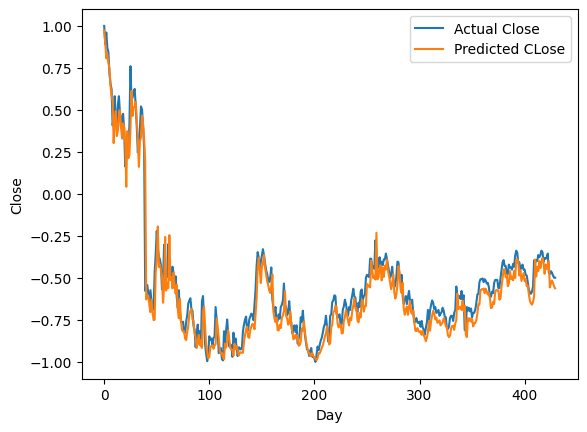

In [121]:
with torch.no_grad(): 
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted CLose')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [130]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))

dummies[:, 0] = train_predictions 
dummies = scaler.inverse_transform(dummies)
train_predictions = dc(dummies[:, 0])
train_predictions

array([6.83731075, 6.66754764, 6.45650091, 6.50956401, 6.39249781,
       6.32099054, 6.08741706, 5.94444246, 5.87374213, 5.29944727,
       5.61789717, 5.73768227, 5.39549706, 5.47028605, 5.67308467,
       5.74980729, 5.52067568, 5.36020503, 5.56889947, 5.52324896,
       5.30709863, 4.70293114, 5.46215626, 5.09402265, 5.13727204,
       5.50784706, 6.01358295, 5.67071938, 5.78417549, 5.79345578,
       5.85958765, 5.61206235, 5.35343037, 4.97515618, 5.32132383,
       5.37687041, 5.67539687, 5.55932563, 5.35564922, 5.04123234,
       3.16426288, 3.2246273 , 3.21370249, 3.08275128, 2.99060076,
       3.16249019, 2.98799391, 2.88093997, 2.88724652, 3.52889707,
       3.71128765, 4.15933868, 3.60671711, 3.63989528, 3.56782956,
       3.47964459, 3.1186666 , 3.33594575, 4.0170618 , 3.28536242,
       3.3818747 , 3.31918386, 4.0426172 , 3.42929456, 3.46770765,
       3.31366673, 3.52855351, 3.34845352, 3.24179519, 3.36357814,
       3.03376747, 2.90780098, 3.17214925, 2.87787239, 2.74640

In [129]:
dummies = np.zeros((X_train.shape[0], lookback+1))
print(y_train.shape)

dummies[:, 0] = y_train.flatten() 
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train.shape

torch.Size([430, 1])


(430,)

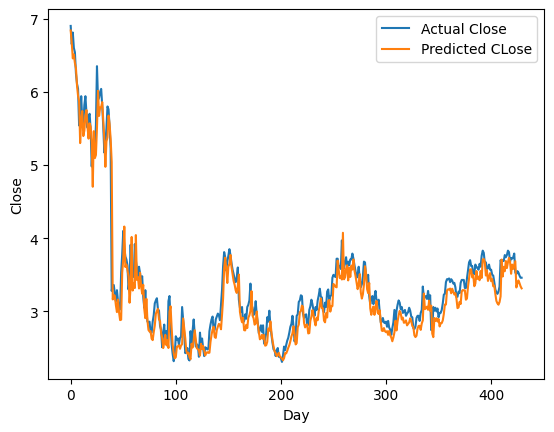

In [133]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted CLose')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [142]:
y_test.shape[0]


48

(48,)


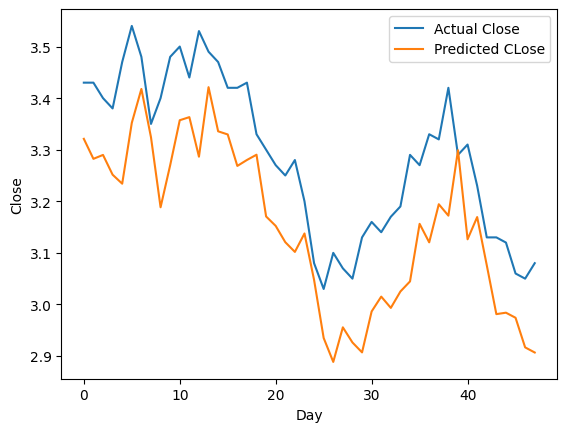

In [144]:
with torch.no_grad(): 
    predicted = model(X_test.to(device)).to('cpu').numpy().flatten()



print(predicted.shape)
dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = predicted
dummies = scaler.inverse_transform(dummies)

new_predicted = dc(dummies[:, 0])


dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)


new_test = dc(dummies[:, 0])

plt.plot(new_test, label='Actual Close')
plt.plot(new_predicted, label='Predicted CLose')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [19]:
print(type(dates_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


LSTM have consist of an input, hidden state and a cell state.

Forget gate decide how much of previous cell state (long term memory) carried on (C o f)

Update gate for updating cell state, output gate for updating values of hidden (short term memry) units. 

